# LSTM Strategy

In this notebook, I will build a strategy for trading cryptofutures using an LSTM classifier model. 

We need to build a good model first. This model should...predict whether the cryptocurrency will go up or down based on data from the past 20 days. It will be compared to a RidgeClassifier, and should be better at correctly predicting positive days.

In [193]:
import xarray as xr
import qnt.data as qndata
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [5]:
def load_data(period):
    return qndata.cryptofutures.load_data(tail=period)

In [6]:
data =load_data(365*50)
data

| |   #                                           | 27682 Elapsed Time: 0:00:00


<xarray.DataArray 'cryptofutures' (field: 7, time: 1993, asset: 1)>
array([[[   97.],
        [  110.],
        [  120.],
        ...,
        [50970.],
        [48125.],
        [50580.]],

       [[  110.],
        [  120.],
        [  153.],
        ...,
        [52190.],
        [49745.],
        [52425.]],

       [[   96.],
        [  103.],
        [  105.],
        ...,
...
        ...,
        [11795.],
        [ 8929.],
        [ 7528.]],

       [[    0.],
        [    0.],
        [    0.],
        ...,
        [ 6570.],
        [ 6164.],
        [ 6507.]],

       [[    0.],
        [    0.],
        [    0.],
        ...,
        [    0.],
        [    0.],
        [    0.]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-04-01 2013-04-02 ... 2021-03-08
  * field    (field) object 'open' 'high' 'low' 'close' 'vol' 'oi' 'roll'
  * asset    (asset) object 'BTC'

In [7]:
data.shape

(7, 1993, 1)

In [15]:
data_df = data[:,:,0].to_pandas().transpose()
data_df

field,open,high,low,close,vol,oi,roll
time,,,,,,,
2013-04-01,97.0,110.0,96.0,108.0,0.0,0.0,0.0
2013-04-02,110.0,120.0,103.0,120.0,0.0,0.0,0.0
2013-04-03,120.0,153.0,105.0,128.0,0.0,0.0,0.0
2013-04-04,128.0,149.0,118.0,139.0,0.0,0.0,0.0
2013-04-05,139.0,151.0,133.0,150.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2021-03-02,49425.0,50550.0,47245.0,47820.0,5993.0,6554.0,0.0
2021-03-03,48035.0,53000.0,47955.0,50900.0,6344.0,6719.0,0.0
2021-03-04,50970.0,52190.0,47425.0,48310.0,11795.0,6570.0,0.0


## Cut the data in Training, Validation, and Test sets

We want to test the strategy on entirely new data. We need a training set to train the model, and validation set to check for overfitting, and then a test set to actually backtest on.

In [16]:
test_df = data_df['2019-01-01':]
valid_df = data_df['2017-01-01':"2019-01-01"]
train_df = data_df[:'2017-01-01']

In [20]:
train_df.shape

(943, 7)

In [21]:
train_close = train_df['close']
train_close.shape

(943,)

In [54]:
valid_close = valid_df['close']
valid_close.shape

(503,)

## Slice Training Data into sequences, get targets

In [426]:
def get_sequence_and_target(sequence, lookback_period=20):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + lookback_period
        if end_ix > len(sequence)-1:
            break
        x_seq = np.log(sequence[i:end_ix])
        X.append(x_seq)
        
        y_seq = np.log(sequence[end_ix])
        y.append(y_seq)
    return np.array(X), np.array(y)

In [427]:
X_train, y_train = get_sequence_and_target(train_close)

In [429]:
X_train.shape

(923, 20)

In [430]:
y_train.shape

(923,)

In [431]:
train_close.shape

(943,)

In [432]:
X_valid, y_valid = get_sequence_and_target(valid_close)
X_valid.shape

(483, 20)

In [433]:
y_valid.shape

(483,)

## Build and Validate Ridge Classifier

In [441]:
y_train_class = (np.diff(y_train) > 0)*1
y_valid_class = (np.diff(y_valid) > 0)*1

In [443]:
ridge_model = RidgeClassifier()
ridge_model.fit(X_train[1:], y_train_class)

ridge_val_pred = ridge_model.predict(X_valid[1:])
accuracy_score(y_valid_class, ridge_val_pred)

0.47717842323651455

In [445]:
precision_score(y_valid_class, ridge_val_pred)

1.0

In [446]:
recall_score(y_valid_class, ridge_val_pred)

0.007874015748031496

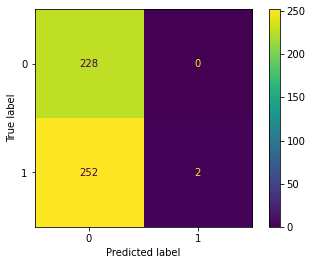

In [448]:
confmat = confusion_matrix(y_valid_class, ridge_val_pred)
confmat = confmat / confmat.sum()
plot_confusion_matrix(ridge_model, X_valid[1:], y_valid_class);

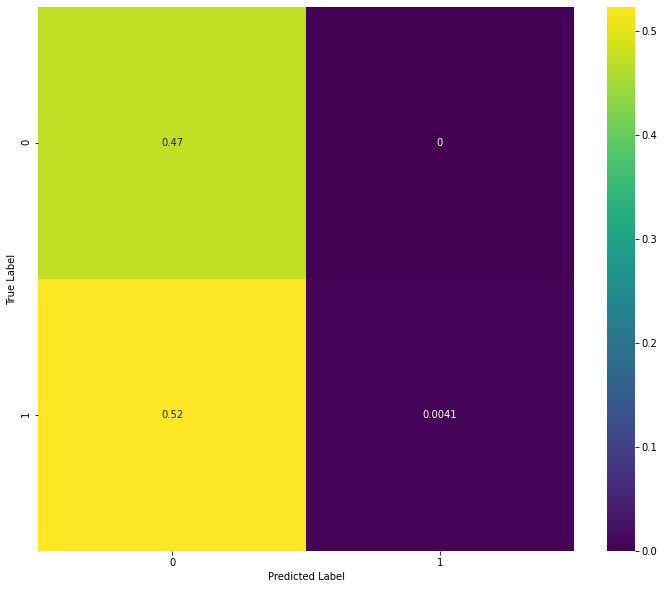

In [449]:
plt.figure(figsize=(12,10))
sns.heatmap(confmat, annot=True, cmap='viridis')
plt.ylabel('True Label')
plt.xlabel('Predicted Label');

The RidgeClassifier often predicts a 0 when the real value would be a 1. 

In [451]:
np.unique(y_valid_class, return_counts=True)

(array([0, 1]), array([228, 254]))

In fact, the RidgeClassifier is worse than just assuming every day has a positive change.

In [452]:
255 / (228+254)

0.529045643153527

Surely we can beat that with a more sophisticated model, right?

## LSTM Model

I started with a single-layer LSTM model, then added layers repeatedly, checking the training and validation loss and metrics, until I had a model I felt was pretty good.

In [453]:
lookback_period = 20
n_timesteps = 2
n_features = 1

X_train_lstm = X_train.reshape(X_train.shape[0], int(lookback_period/n_timesteps), n_timesteps, n_features)
X_train_lstm.shape

(923, 10, 2, 1)

In [454]:
X_valid_lstm = X_valid.reshape(X_valid.shape[0], int(lookback_period/n_timesteps), n_timesteps, n_features)
X_valid_lstm.shape

(483, 10, 2, 1)

In [693]:
model = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=128, 
                                                           kernel_size=1,
                                                           activation='relu'),
                                   input_shape=(None, n_timesteps, n_features)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=128,
                                                           kernel_size = 1,
                                                           activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    tf.keras.layers.LSTM(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [694]:
#initial_learning_rate = 0.5
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate,
#    decay_steps=100000,
#    decay_rate=0.96,
#    staircase=True)

#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer='adam', loss='mae')

In [695]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
checkpoint_path = "training_1/cp.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True)

history = model.fit(X_train_lstm, y_train, epochs=200, verbose=True, 
                    validation_data = (X_valid_lstm, y_valid), batch_size = 32,
                    callbacks=[checkpoint])

Epoch 1/200
29/29 [==============================] - 3s 32ms/step - loss: 3.1565 - val_loss: 1.3679
Epoch 2/200
29/29 [==============================] - 1s 17ms/step - loss: 0.3186 - val_loss: 1.2553
Epoch 3/200
29/29 [==============================] - 1s 18ms/step - loss: 0.1711 - val_loss: 1.2112
Epoch 4/200
29/29 [==============================] - 1s 18ms/step - loss: 0.3379 - val_loss: 1.0970
Epoch 5/200
29/29 [==============================] - 1s 18ms/step - loss: 0.1928 - val_loss: 0.6278
Epoch 6/200
29/29 [==============================] - 1s 18ms/step - loss: 0.1417 - val_loss: 0.5489
Epoch 7/200
29/29 [==============================] - 1s 18ms/step - loss: 0.1437 - val_loss: 1.0870
Epoch 8/200
29/29 [==============================] - 1s 17ms/step - loss: 0.2047 - val_loss: 0.8420
Epoch 9/200
29/29 [==============================] - 1s 18ms/step - loss: 0.2261 - val_loss: 0.6642
Epoch 10/200
29/29 [==============================] - 1s 18ms/step - loss: 0.1245 - val_loss: 0.8657

29/29 [==============================] - 1s 18ms/step - loss: 0.0666 - val_loss: 0.1658
Epoch 163/200
29/29 [==============================] - 1s 19ms/step - loss: 0.0616 - val_loss: 0.4412
Epoch 164/200
29/29 [==============================] - 1s 21ms/step - loss: 0.0677 - val_loss: 0.1627
Epoch 165/200
29/29 [==============================] - 1s 21ms/step - loss: 0.0821 - val_loss: 0.4501
Epoch 166/200
29/29 [==============================] - 1s 19ms/step - loss: 0.0871 - val_loss: 0.4621
Epoch 167/200
29/29 [==============================] - 1s 19ms/step - loss: 0.0564 - val_loss: 0.1502
Epoch 168/200
29/29 [==============================] - 1s 20ms/step - loss: 0.0588 - val_loss: 0.2450
Epoch 169/200
29/29 [==============================] - 1s 18ms/step - loss: 0.1152 - val_loss: 0.2173
Epoch 170/200
29/29 [==============================] - 1s 19ms/step - loss: 0.0785 - val_loss: 0.2185
Epoch 171/200
29/29 [==============================] - 0s 17ms/step - loss: 0.0509 - val_loss: 0

In [696]:
def plot_loss(history, start=0):
    plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'][start:], label='Training Loss')
    plt.plot(history.history['val_loss'][start:], label='Validation Loss')
    plt.title('Loss, from epoch ' + str(start))
    plt.legend()
    plt.show();

def plot_metric(history, metric, start=0):
    plt.figure(figsize=(12,8))
    plt.plot(history.history[metric][start:], label='Training ' + metric)
    plt.plot(history.history['val_' + metric][start:], label='Validation ' + metric)
    plt.title(metric + ', from epoch ' + str(start))
    plt.legend()
    plt.show();

In [697]:
model.load_weights(checkpoint_path)

In [698]:
lstm_pred = model.predict(X_valid_lstm)
lstm_pred = lstm_pred.reshape(lstm_pred.shape[0],)

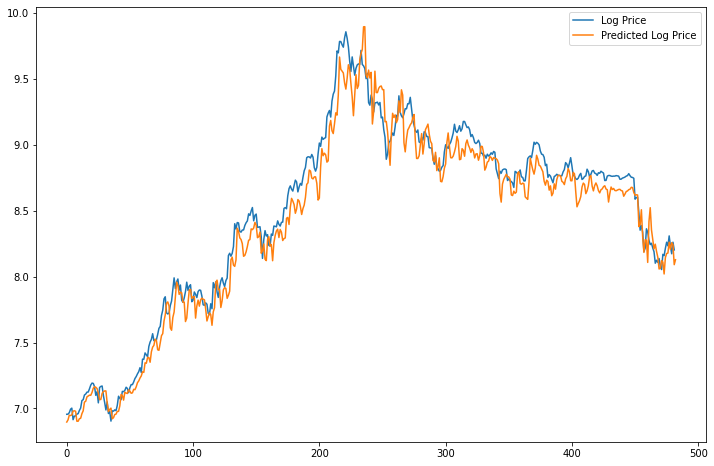

In [699]:
plt.figure(figsize=(12,8))
plt.plot(np.log(np.array(valid_close)[21:]), label='Log Price')
plt.plot(lstm_pred, label='Predicted Log Price')
plt.legend();

In [700]:
lstm_pred_class = (np.diff(lstm_pred) > 0)*1

In [701]:
accuracy_score(y_valid_class, lstm_pred_class)

0.4979253112033195

In [702]:
precision_score(y_valid_class, lstm_pred_class)

0.5227272727272727

In [703]:
recall_score(y_valid_class, lstm_pred_class)

0.5433070866141733

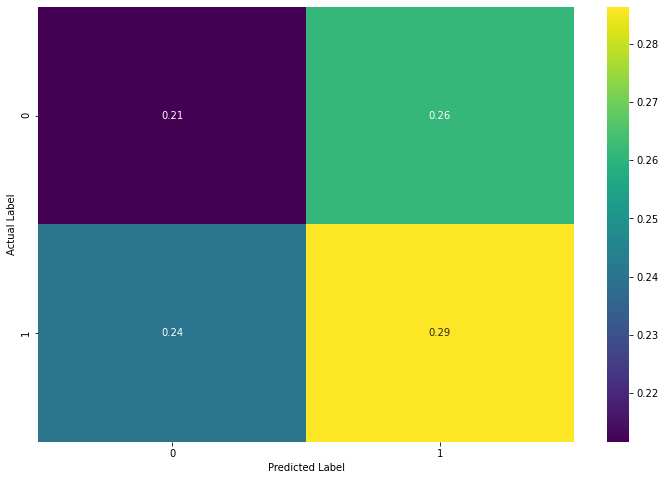

In [704]:
plt.figure(figsize=(12,8))
confmat = confusion_matrix(y_valid_class, lstm_pred_class)
confmat = confmat / confmat.sum()
sns.heatmap(confmat, annot=True, cmap='viridis')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');

## Saving and Loading the Model

In [718]:
model.save('model.h5')

In [719]:
loaded_model = tf.keras.models.load_model('model.h5')

# Code to be deployed to Quantiacs

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

In [61]:
import xarray as xr
import qnt.backtester as qnbt
import qnt.data as qndata
import numpy as np
import logging
import tensorflow as tf
import pandas as pd

def load_data(period):
    return qndata.cryptofutures.load_data(tail=period)

def predict_weights(market_data):
    
    def get_tf_model():
        model = tf.keras.models.load_model('model.h5')
        return model
    
    def get_sequence_and_target(sequence, lookback_period=20):
        X, y = list(), list()
        for i in range(len(sequence)):
            end_ix = i + lookback_period
            if end_ix > len(sequence)-1:
                break
            x_seq = np.log(sequence[i:end_ix])
            X.append(x_seq)
        
            y_seq = np.log(sequence[end_ix])
            y.append(y_seq)
        return np.array(X), np.array(y)
    
    lookback_period = 20
    n_timesteps = 2
    n_features = 1
    
    data = market_data.copy(True)
    
    predict_df = data.sel(field='close').isel(time=-1).to_pandas()
    
    asset_name_all = data.coords['asset'].values
    close = data.sel(field='close')
    
    features, target = get_sequence_and_target(close)
    features = features.reshape(features.shape[0], int(lookback_period/2), n_timesteps, n_features)
    
    model = get_tf_model()
    
    try:
        model.fit(features, target, verbose=False, epochs=10)
        predict_features =  np.append(features[-1].reshape(20,), target[-1])[1:].reshape(1, int(lookback_period/2), 
                                                                                         n_timesteps, n_features)
        predict = model.predict(predict_features)
        predict_class = (predict > target[-1]) * 1
        predict_df[asset_name_all] = predict_class
    except:
        logging.exception('Model Failed')
        return xr.zeros_like(data.isel(field=0, time=0))
    
    model.save('model.h5')
    
    return predict_df.to_xarray()



In [62]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [63]:
weights = qnbt.backtest(competition_type = 'cryptofutures',
                        load_data = load_data,
                        lookback_period=40,
                        start_date = '2014-01-01',
                        strategy = predict_weights,
                        analyze=True,
                        build_plots=True)

Run last pass...
Load data...


| |#                                                | 862 Elapsed Time: 0:00:00


Run pass...
Ok.
---
Run first pass...
Load data...
Run pass...
Ok.
---
Load full data...


| | #                                             | 26102 Elapsed Time: 0:00:00


---
Run iterations...



100% (1802 of 1802) |####################| Elapsed Time: 1:07:07 Time:  1:07:07


Merge outputs...
Load data for cleanup and analysis...


| |   #                                           | 26551 Elapsed Time: 0:00:00


Check missed dates...
Ok.
ffill if the current price is None...
Normalization...
Done.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz
---
Analyze results...
Check...
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2014-01-01 - 2021-03-09
Sharpe Ratio = -0.5153850362010103


ERROR! The sharpe ratio is too low. -0.5153850362010103 < 1


Check correlation.


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'
WARNING! Can't calculate correlation.
Correlation check failed.


---
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Output:


asset,BTC
time,
2021-02-24,0.0
2021-02-25,0.0
2021-02-26,1.0
2021-03-01,0.0
2021-03-02,0.0
2021-03-03,0.0
2021-03-04,0.0
2021-03-05,1.0
2021-03-08,0.0


Stats:


field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2021-02-24,0.112486,0.033899,0.491388,-0.901916,-0.958855,-0.536266,-0.263514,0.0,1.0,0.314649,2.742537
2021-02-25,0.112222,-0.002350,0.491251,-0.902147,-0.958855,-0.536653,-0.263631,0.0,1.0,0.315040,2.739777
2021-02-26,0.112222,0.000000,0.491114,-0.902147,-0.958855,-0.536546,-0.263506,1.0,1.0,0.314865,2.739777
2021-03-01,0.119861,0.068072,0.491651,-0.895486,-0.958855,-0.521853,-0.256569,0.0,1.0,0.315246,2.739777
2021-03-02,0.120709,0.007082,0.491522,-0.894746,-0.958855,-0.520248,-0.255713,0.0,1.0,0.315671,2.733333
2021-03-03,0.120709,0.000000,0.491386,-0.894746,-0.958855,-0.520144,-0.255591,0.0,1.0,0.315495,2.733333
2021-03-04,0.120709,0.000000,0.491249,-0.894746,-0.958855,-0.520040,-0.255469,0.0,1.0,0.315320,2.733333
2021-03-05,0.120709,0.000000,0.491113,-0.894746,-0.958855,-0.519936,-0.255347,1.0,1.0,0.315145,2.733333
2021-03-08,0.123969,0.027003,0.491085,-0.891904,-0.958855,-0.514074,-0.252454,0.0,1.0,0.315525,2.733333


---
